In [28]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import preprocess_input


In [29]:
import numpy as np
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

Getting dataset from kaggle (Uncomment if you wish to check however we have kept local copy)

In [30]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("goubeast/age-prediction-av")
#print("Path to dataset files:", path)

In [31]:
#! ls data/train/old


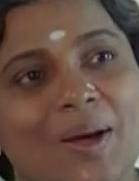

In [32]:
path = './data/train/old'
#name = '82.headshot.jpg'
name = '10019.jpg'
fullname = f'{path}/{name}'
load_img(fullname)

In [33]:
img = load_img(fullname, target_size=(200, 200))
x = np.array(img)
x.shape

(200, 200, 3)

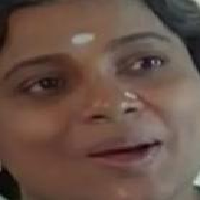

In [34]:
img

Model from scratch

In [35]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(200, 200, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))


In [36]:
model.compile(loss='binary_crossentropy',\
             optimizer=optimizers.SGD(learning_rate=0.002, momentum=0.8),\
             metrics=['acc'])

In [37]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 313632)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │    20,072,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,073,473 (76.57 MB)

 Trainable params: 20,073,473 (76.57 MB)

 Non-trainable params: 0 (0.00 B)

Transfer learning: Reusing Imagenet model

In [38]:
from keras.applications.xception import Xception

In [39]:
# modify create model function
def create_model(learning_rate=0.001, size_inner=100):
  base_model = Xception(
      weights='imagenet',
      include_top=False,
      input_shape=(200, 200, 3)
  )
  base_model.trainable = False

  inputs = keras.Input(
      shape=(200,200,3)
  )

  base = base_model(inputs, training=False)

  vectors = keras.layers.GlobalAveragePooling2D()(base)

  # adding inner layer
  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)

  # 2 classes
  outputs = keras.layers.Dense(2)(inner)

  model = keras.Model(inputs, outputs)

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  loss = keras.losses.SparseCategoricalCrossentropy(
      from_logits=True
  )

  model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=['accuracy']
  )

  return model


In [40]:
train_dir = 'data/train'
test_dir = 'data/test'

#train_datagen = ImageDataGenerator(rescale=1./255)
#val_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [41]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 6830 images belonging to 2 classes.


In [42]:
train_generator.class_indices

{'old': 0, 'young': 1}

In [43]:
validation_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 2281 images belonging to 2 classes.


In [44]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 200, 200, 3)
labels batch shape: (20,)


In [45]:
model = create_model()

In [46]:
history = model.fit(
    train_generator,
    epochs=1,
    validation_data=validation_generator,
)

I0000 00:00:1738436384.241650    4598 service.cc:148] XLA service 0x7f5384001cf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738436384.241679    4598 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-02-01 18:59:44.341696: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738436385.036102    4598 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-01 18:59:48.132274: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


  3/342 ━━━━━━━━━━━━━━━━━━━━ 20s 59ms/step - accuracy: 0.7556 - loss: 0.5481

I0000 00:00:1738436389.013415    4598 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


342/342 ━━━━━━━━━━━━━━━━━━━━ 43s 102ms/step - accuracy: 0.8069 - loss: 0.4294 - val_accuracy: 0.8637 - val_loss: 0.3147


Find the best learning rate for Adam optimizer

In [47]:
scores = {}

for lr in [0.0001, 0.001, 0.01, 0.1]:
    print(lr)

    model = create_model(learning_rate=lr)
    history = model.fit(
    train_generator,
    epochs=1,
    validation_data=validation_generator,
    )
    scores[lr] = history.history

    print()
    print()

0.0001
342/342 ━━━━━━━━━━━━━━━━━━━━ 38s 94ms/step - accuracy: 0.7734 - loss: 0.4696 - val_accuracy: 0.8422 - val_loss: 0.3560


0.001
342/342 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.8026 - loss: 0.4243 - val_accuracy: 0.8645 - val_loss: 0.3182


0.01
342/342 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.7641 - loss: 0.6210 - val_accuracy: 0.8505 - val_loss: 0.3325


0.1
342/342 ━━━━━━━━━━━━━━━━━━━━ 38s 94ms/step - accuracy: 0.7357 - loss: 2.6152 - val_accuracy: 0.7356 - val_loss: 0.5095




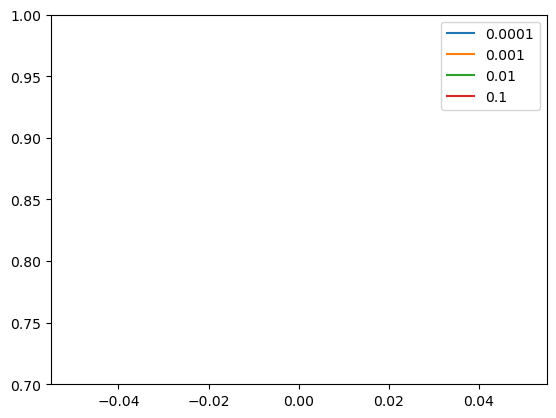

In [48]:
for lr, hist in scores.items():
  plt.plot(
      hist['accuracy'],
      label=lr
  )

plt.ylim(0.70, 1)
plt.legend()

In [49]:
# Best learning rate
learning_rate = 0.001

Find the best size for inner layer

In [50]:
scores = {}

for size in [10, 100, 1000]:
    print(size)

    model = create_model(learning_rate, size_inner=size)
    history = model.fit(
    train_generator,
    epochs=1,
    validation_data=validation_generator,
    )
    scores[size] = history.history

    print()
    print()

10
342/342 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.7764 - loss: 0.4540 - val_accuracy: 0.8343 - val_loss: 0.3664


100
342/342 ━━━━━━━━━━━━━━━━━━━━ 38s 96ms/step - accuracy: 0.8032 - loss: 0.4297 - val_accuracy: 0.8663 - val_loss: 0.3195


1000
342/342 ━━━━━━━━━━━━━━━━━━━━ 39s 96ms/step - accuracy: 0.8092 - loss: 0.4476 - val_accuracy: 0.8435 - val_loss: 0.3402




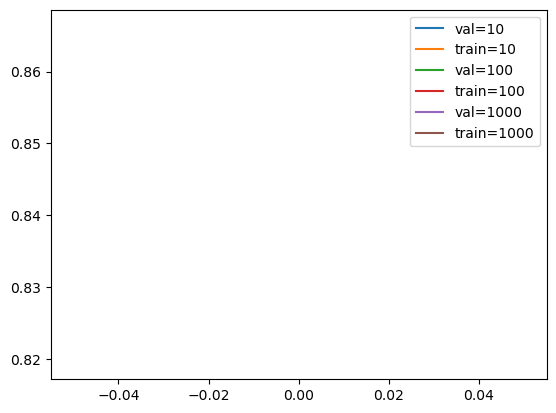

In [51]:
for size, hist in scores.items():
  plt.plot(
      hist['val_accuracy'],
      label=('val=%s' % size),
  )
  plt.plot(
      hist['accuracy'],
      label=('train=%s' % size)
  )

  plt.legend()

In [52]:
# Best size
size_inner = 100

Dropout and regularization

In [55]:
def create_model(learning_rate=0.001, size_inner=100, drop_rate=0.5):
  base_model = Xception(
      weights='imagenet',
      include_top=False,
      input_shape=(200, 200, 3)
  )
  base_model.trainable = False

  inputs = keras.Input(
      shape=(200,200,3)
  )

  base = base_model(inputs, training=False)

  vectors = keras.layers.GlobalAveragePooling2D()(base)

  # adding inner layer
  inner = keras.layers.Dense(size_inner, activation='relu')(vectors)

  # dropout
  drop = keras.layers.Dropout(drop_rate)(inner)

  # 2 classes
  outputs = keras.layers.Dense(2)(drop)

  model = keras.Model(inputs, outputs)

  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

  loss = keras.losses.SparseCategoricalCrossentropy(
      from_logits=True
  )

  model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=['accuracy']
  )

  return model

Find the best drop out rate

In [63]:
scores = {}

for drop_rate in [0.0, 0.2, 0.5, 0.8]:
    print(drop_rate)

    model = create_model(drop_rate = drop_rate)
    history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    )
    scores[drop_rate] = history.history

    print()
    print()

0.0
Epoch 1/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 36s 92ms/step - accuracy: 0.8062 - loss: 0.4242 - val_accuracy: 0.8680 - val_loss: 0.3146
Epoch 2/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 78ms/step - accuracy: 0.8707 - loss: 0.2975 - val_accuracy: 0.8694 - val_loss: 0.3075
Epoch 3/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.9016 - loss: 0.2443 - val_accuracy: 0.8553 - val_loss: 0.3282
Epoch 4/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.9196 - loss: 0.2080 - val_accuracy: 0.8847 - val_loss: 0.2917
Epoch 5/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.9352 - loss: 0.1714 - val_accuracy: 0.8869 - val_loss: 0.2891
Epoch 6/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.9492 - loss: 0.1350 - val_accuracy: 0.8825 - val_loss: 0.3302
Epoch 7/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.9563 - loss: 0.1143 - val_accuracy: 0.8821 - val_loss: 0.3277
Epoch 8/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.9666 - loss: 0.089

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.9576 - loss: 0.1133 - val_accuracy: 0.8900 - val_loss: 0.3254
Epoch 10/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.9503 - loss: 0.1213 - val_accuracy: 0.8957 - val_loss: 0.2986
Epoch 11/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 80ms/step - accuracy: 0.9725 - loss: 0.0820 - val_accuracy: 0.8922 - val_loss: 0.3251
Epoch 12/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.9755 - loss: 0.0720 - val_accuracy: 0.8930 - val_loss: 0.3353
Epoch 13/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.9772 - loss: 0.0658 - val_accuracy: 0.8843 - val_loss: 0.3382
Epoch 14/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.9802 - loss: 0.0592 - val_accuracy: 0.8930 - val_loss: 0.3884
Epoch 15/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.9778 - loss: 0.0541 - val_accuracy: 0.8821 - val_loss: 0.3713
Epoch 16/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.9836 - loss: 0.0465 - val_

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.9574 - loss: 0.1145 - val_accuracy: 0.8904 - val_loss: 0.3483


0.8
Epoch 1/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 38s 95ms/step - accuracy: 0.7604 - loss: 0.5421 - val_accuracy: 0.8312 - val_loss: 0.3847
Epoch 2/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.7871 - loss: 0.4439 - val_accuracy: 0.8431 - val_loss: 0.3536
Epoch 3/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.8218 - loss: 0.4072 - val_accuracy: 0.8439 - val_loss: 0.3475
Epoch 4/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.8264 - loss: 0.3959 - val_accuracy: 0.8553 - val_loss: 0.3270
Epoch 5/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.8365 - loss: 0.3641 - val_accuracy: 0.8518 - val_loss: 0.3252
Epoch 6/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.8431 - loss: 0.3592 - val_accuracy: 0.8588 - val_loss: 0.3173
Epoch 7/20
342/342 ━━━━━━━━━━━━━━━━━━━━ 27s 79ms/step - accuracy: 0.8298 - loss: 0.3644 - val_a

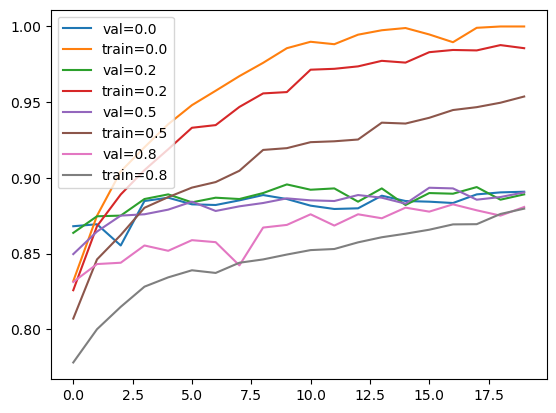

In [64]:
for drop, hist in scores.items():
  plt.plot(
      hist['val_accuracy'],
      label=('val=%s' % drop),
  )
  plt.plot(
      hist['accuracy'],
      label=('train=%s' % drop)
  )

plt.legend()

In [ ]:
drop_rate = 0.2

Data Augmentation

In [57]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [58]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [59]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 6830 images belonging to 2 classes.


In [60]:
validation_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=20,
    class_mode='binary'
)

Found 2281 images belonging to 2 classes.


In [61]:
# Create checkpoint
checkpoint = keras.callbacks.ModelCheckpoint(
    'xception_v1_{epoch:02d}_{val_accuracy:.3f}.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max'#max monitor variable
)

In [62]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

Epoch 1/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.7786 - loss: 0.6204

/opt/saturncloud/envs/saturn/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


342/342 ━━━━━━━━━━━━━━━━━━━━ 61s 180ms/step - accuracy: 0.7787 - loss: 0.6199 - val_accuracy: 0.8729 - val_loss: 0.3043
Epoch 2/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 61s 178ms/step - accuracy: 0.8435 - loss: 0.3599 - val_accuracy: 0.8615 - val_loss: 0.3475
Epoch 3/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 62s 181ms/step - accuracy: 0.8489 - loss: 0.3528 - val_accuracy: 0.8751 - val_loss: 0.3069
Epoch 4/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 61s 179ms/step - accuracy: 0.8506 - loss: 0.3388 - val_accuracy: 0.8724 - val_loss: 0.3087
Epoch 5/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 61s 178ms/step - accuracy: 0.8624 - loss: 0.3286 - val_accuracy: 0.8575 - val_loss: 0.3893
Epoch 6/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 61s 178ms/step - accuracy: 0.8591 - loss: 0.3213 - val_accuracy: 0.8658 - val_loss: 0.3344
Epoch 7/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 60s 176ms/step - accuracy: 0.8757 - loss: 0.2937 - val_accuracy: 0.8715 - val_loss: 0.3066
Epoch 8/10
342/342 ━━━━━━━━━━━━━━━━━━━━ 60s 176ms/step - accuracy: 0.8775 - loss: 0.3021 - val

In [57]:
acc_aug = history.history['accuracy']
val_acc_aug = history.history['val_accuracy']
loss_aug = history.history['loss']
val_loss_aug = history.history['val_loss']

epochs_aug = range(1, len(acc) + 1)

plt.plot(epochs_aug, acc_aug, 'bo', label='Training acc')
plt.plot(epochs_aug, val_acc_aug, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_aug, loss_aug, 'bo', label='Training loss')
plt.plot(epochs_aug, val_loss_aug, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

NameError: name 'acc' is not defined

In [64]:
loss_mean_aug = np.mean(val_loss_aug)
loss_mean_aug

np.float64(0.3287494510412216)

In [65]:
val_acc_aug[5:10]

[0.8658483028411865,
 0.8715475797653198,
 0.8535729646682739,
 0.8711091876029968,
 0.8746163845062256]

In [66]:
acc_mean_aug = np.mean(val_acc_aug[5:10])
acc_mean_aug

np.float64(0.8673388838768006)

Using a saved model via checkpoint

In [67]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

In [68]:
model = keras.models.load_model('xception_v1_08_0.893.keras')

In [69]:
model.evaluate(validation_generator)

115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.8800 - loss: 0.5655


[0.5033975839614868, 0.8925909399986267]

In [70]:
path = 'data/test/young/10056.jpg'
img = load_img(path, target_size=(200, 200))

In [71]:
import numpy as np
x = np.array(img)
X = np.array([x])
X.shape

(1, 200, 200, 3)

In [72]:
X = preprocess_input(X)
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [73]:
pred[0]

array([-1.584364 ,  1.1029187], dtype=float32)

In [74]:
import tensorflow as tf

probabilities = tf.nn.softmax(pred[0]).numpy()
print(probabilities)

[0.06372795 0.936272  ]


Convert model to TF-Lite

In [75]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

with open('model.tflite', 'wb') as f_out:
    f_out.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpdf2dhejp/assets


INFO:tensorflow:Assets written to: /tmp/tmpdf2dhejp/assets


Saved artifact at '/tmp/tmpdf2dhejp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name='input_layer_10')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  139903753822352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139903753824848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139903753824080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139903753825040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139903753825616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139903753823696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139903753824656: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139903753823888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139903753825808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139903753826576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139903753826

W0000 00:00:1737913702.483635    1251 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1737913702.483664    1251 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-01-26 17:48:22.484124: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpdf2dhejp
2025-01-26 17:48:22.497140: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-01-26 17:48:22.497167: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpdf2dhejp
I0000 00:00:1737913702.612196    1251 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
2025-01-26 17:48:22.632581: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-01-26 17:48:23.482238: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpdf2dhejp
2025-01-26 17:48:23.668402: I tensorflow/cc/saved_model/loader.cc:466] SavedModel 